In [1]:
# Import libraries

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from pprint import pprint
from scipy import constants
from scipy import stats
from scipy import signal
from scipy import fft

import matplotlib.pyplot as plt
from io import StringIO
from numpy import random

import plotly.graph_objects as go
import seaborn as sns
import matplotlib as mpl

import requests


# Loading datasets, Extracting features and training labels

I extracted features using the fact that (sin(theta))^2 values at the peaks in the XRD data are related to h^2+k^2+l^2 values and they need to be an integer. Since here I don't know the lattice parameter and other structural information, I used the ratio of (sin(theta))^2 as my features. Since number of peaks can be different, I used the histogram to get equal feature size for all datas alongwith taking the information of the peaks. In my feature list, the bin size is a variable as it is part of the feature engineering. For random forest classifier, I showed how this feature engineering can come into play.

Secondly, sin(theta) values are related with q parameter. Since for XRD we don't know the phase information, it is hard to use Fourier transform to back track the diffraction planes. However, since sin(theta) is related with q and data points are given in 2*theta, I used Discrete Sine Transform (DST) of type 4 to extract another set of parameters. DST transform takes the whole spectrum into account whereas the (sin(theta))^2 takes only the information of the peak locations. Again, for my models I have the option to tune the number of DST coefficients for calculation. As in the random forest classifier, it is shown that number of DST coefficients can also play a role in the model's accuracy.

Based on this material properties, I extracted my features and then applied 4 machine learning models. I optimized 4 models (Naive Bayes, KNN, Random Forest Classfier and lightgbm (Gradient boost classifier)).

In [2]:
# function for calculating features
def calculate_features(data_filepath,nbins_sin2theta_s,strt_bin,end_bin,coeff_num):
    # data_filepath: location of csv file containing data for XRD from angle 0.5 to 180 degrees in y0 to y179 columns
    #                and labels for bravais lattice in "bravais_lattice" column
    # nbins_sin2theta_s,strt_bin,end_bin: binning conditions for (sin(theta))^2 from 'strt_bin' to 'end_bin' in 'nbins_sin2theta_s' bins
    # coeff_num: number of coefficients of DST transform of XRD data used for classification
    # calc_features: list of all features without applying (sin(theta))^2 binning or isolating DST coefficients
    # final_feature: dataframe containing list of features that will be used for final classification
    
    # loading data in dataframe
    orig_data=pd.read_csv(data_filepath,na_filter=False)
    # isolating columns of the XRD data
    orig_features=orig_data.filter(regex='^y')
    calc_features=orig_features.copy()
    #combination of all intensity data
    calc_features['combined_data']=calc_features.values.tolist()

    #find the peak indices
    calc_features['peak_indices']=calc_features.apply(lambda x: signal.find_peaks(x['combined_data']),axis=1)

    #find the peak heights, widths and prominences
    calc_features['peak_heights']=calc_features.apply(lambda x: [x['combined_data'][j] for j in x['peak_indices'][0]],axis=1)
    calc_features['peak_widths']=calc_features.apply(lambda x: signal.peak_widths(x['combined_data'],x['peak_indices'][0])[0],axis=1)
    calc_features['peak_prominences']=calc_features.apply(lambda x: signal.peak_prominences(x['combined_data'],x['peak_indices'][0])[0],axis=1)

    # find the corresponding sin(theta), (sin(theta))^2
    calc_features['peak_angles (2theta Deg)']=calc_features.apply(lambda x: (x['peak_indices'][0]+1)*0.5,axis=1)
    calc_features['sin(theta)_peak']=calc_features.apply(lambda x: np.sin(np.deg2rad(x['peak_angles (2theta Deg)']/2)),axis=1)
    calc_features['sin2theta_peak']=calc_features.apply(lambda x: x['sin(theta)_peak']**2,axis=1)

    # normalize (sin(theta))^2 based on the first peak as this value corresponds to h^2+k^2+l^2
    calc_features['sin2theta_ratio_peak']=calc_features.apply(lambda x: x['sin2theta_peak']/x['sin2theta_peak'][0],axis=1)

    # find total number of peak in the XRD data
    calc_features['peak_num_tot']=calc_features.apply(lambda x: len(x['peak_heights']),axis=1)

    # Calculate statistics of peak heights
    calc_features['skew_peak_heights']=calc_features.apply(lambda x: stats.skew(x['peak_heights']),axis=1)
    calc_features['kurt_peak_heights']=calc_features.apply(lambda x: stats.kurtosis(x['peak_heights']),axis=1)

    # find discrete sin transform coefficients and normalize it
    calc_features['dst_4']=calc_features.apply(lambda x: fft.dst(x['combined_data'],type=4),axis=1)
    calc_features['dst_4_rat']=calc_features.apply(lambda x: x['dst_4']/abs(x['dst_4'][0]),axis=1)

    # convert discrete_sin_transform ration features into dataframe
    dst_transform_features=pd.DataFrame(list(calc_features.apply(lambda x: x['dst_4_rat'], axis=1)),columns=["DST_coeff_ratio"+str(j) for j in range(1,181)])

    # since ration of (sin(theta))^2 represents the (h,k,l) plane and the maximum value represents the number of symmetry in a way
    calc_features['max_sin2theta_ratio_peak']=calc_features.apply(lambda x: max(x['sin2theta_ratio_peak']),axis=1)

    # since in two data points there are only 2 peaks, so I used the value of 2nd ratio. For example for CF it should be 1.33, 
    # for CP it should be 2 and so on. It helps me to identify cubic crystals. Also the ration of total number of peaks to
    # (sin(theta))^2 ration can indicate the missing number of (h+k+l). So I added that as a feature.
    calc_features['sin2theta_2nd']=calc_features.apply(lambda x: x['sin2theta_ratio_peak'][1],axis=1)
    calc_features['ration_totPeak_maxsin2thetaratio']=calc_features.peak_num_tot/calc_features.max_sin2theta_ratio_peak
    # add some statistical features of the (sin(theta))^2 ratios
    calc_features['mean_sin2theta_ratio_peak']=calc_features.apply(lambda x: np.mean(x['sin2theta_ratio_peak']),axis=1)
    calc_features['std_sin2theta_ratio_peak']=calc_features.apply(lambda x: np.std(x['sin2theta_ratio_peak']),axis=1)

    # add some statistical features of the peak heights 
    calc_features['std_peak_heights']=calc_features.apply(lambda x: np.std(x['peak_heights']),axis=1)
    calc_features['mean_peak_heights']=calc_features.apply(lambda x: np.mean(x['peak_heights']),axis=1)


    # binning (sin(theta))^2 from 'strt_bin' to 'end_bin' in 'nbins_sin2theta_s' bins.
    # since number of (sin(theta))^2 values are different for different samples, I am using histogram to get similar number
    # of features in all samples. My bin width is 0.333 as in hexagonal, FCC the divide by 3 is important.
    # nbins_sin2theta_s=45;strt_bin=1;end_bin=16;
    sin2theta_s_stat_feature=pd.DataFrame(list(calc_features.apply(lambda x: np.histogram(x['sin2theta_ratio_peak'],bins=nbins_sin2theta_s,range=(strt_bin,end_bin),density=False)[0],axis=1)),columns=["sin2theta_bin"+str(j) for j in range(nbins_sin2theta_s)])

    # number of coefficients that will be considered in the final feature lists from DST transform
    #coeff_num=20;

    # Construction of final feature dataframe
    final_feature=calc_features.loc[:,'max_sin2theta_ratio_peak':]
    final_feature=final_feature.join(sin2theta_s_stat_feature)
    final_feature=final_feature.join(dst_transform_features.iloc[:,1:coeff_num+1])
    
    return calc_features, final_feature

In [3]:
# function for extracting labels
def extract_labels(data_filepath):
    #extract labels from the column 'bravais_lattice' of the csv file located in the 'data_filepath'
    # loading data in dataframe
    orig_data=pd.read_csv(data_filepath,na_filter=False)
    orig_labels=orig_data['bravais_lattice']
    return orig_labels

In [4]:
# location of training data file and kaggle data file
training_data_filepath="C:\\Users\\Raihan\\Nano281_project\\cod_xrd_42k.csv"
kaggle_data_filepath="C:\\Users\\Raihan\\Nano281_project\\test.csv"

# feature size can be varied based on the binning parameters and number of DST coefficients.
# For model optimization the following parameters are used. Later it will be varied to get the
# optimum performance of different models

nbin_sin2theta=45;start_bin=1;end_bin=16;dst_coeff=20;
# calculate features for training dataset (cod_xrd_42k.csv)
base_feature_training,final_feature_training_45_20=calculate_features(training_data_filepath,nbin_sin2theta,start_bin,end_bin,dst_coeff)

# calculate features for kaggle dataset (test.csv)
base_feature_kaggle,final_feature_kaggle_45_20=calculate_features(kaggle_data_filepath,nbin_sin2theta,start_bin,end_bin,dst_coeff)

In [5]:
# extract training labels and encode labels in numerical values
from sklearn import preprocessing
orig_labels=extract_labels(training_data_filepath)
le = preprocessing.LabelEncoder()
le.fit(orig_labels)
original_labels = le.transform(orig_labels)

# Data pre-processing

In [6]:
# Splitting training data with 10% unseen data for model validation
from sklearn.model_selection import train_test_split
x_train_45_20, x_test_45_20, y_train_45_20, y_test_45_20 = train_test_split(final_feature_training_45_20, original_labels, test_size=0.1, random_state=0)

In [7]:
# Scaling data for better model performance
from sklearn.preprocessing import MinMaxScaler
minmax_scaler=MinMaxScaler()

minmax_scaler_45_20=minmax_scaler
minmax_scaler_45_20.fit(x_train_45_20)
x_test_scaled_45_20=minmax_scaler_45_20.transform(x_test_45_20)
x_train_scaled_45_20=minmax_scaler_45_20.transform(x_train_45_20)
kaggle_scaled_45_20=minmax_scaler_45_20.transform(final_feature_kaggle_45_20)

# Model Selection

In [8]:
# functions for plotting the grid search values
from sklearn.metrics import mean_squared_error, accuracy_score, roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold
def plot_grid_search_results(gs, plot_type='bar', ylim=None):
    """
    Plots the results of GridSearchCV.
    """
    results = pd.DataFrame(gs.cv_results_)
    for c in results.columns:
        # Note that here we are working with just variations in one parameter.
        # So we can automatically find the name of that parameter.
        if c.startswith("param_"):
            x = c
            break
    results = results.melt(id_vars=[x], value_vars=['mean_train_score', 'mean_test_score'],
        var_name="type", value_name='score')
    fig, ax = plt.subplots(figsize=(16, 8))
    if plot_type == "bar":
        ax = sns.barplot(x=x, y="score", hue='type', data=results)
    else:
        ax = sns.scatterplot(x=x, y="score", hue='type', data=results)
    plt.xlabel(x)
    if ylim:
        plt.ylim(ylim)
    return fig

def plot_grid_search_results2(gs, ylim=None):
    """
    Plots the results of GridSearchCV.
    
    Args:
        gs: A GridSearchCV object.
        ylim: Optional setting for y limits.
    """
    results = pd.DataFrame(gs.cv_results_)
    for c in results.columns:
        # Note that here we are working with just variations in one parameter.
        # So we can automatically find the name of that parameter.
        if c.startswith("param_"):
            x = c
            break
    fig, ax = plt.subplots(figsize=(12, 6))    
    ax = sns.lineplot(x=x, y="mean_train_score", data=results)
    ax = sns.scatterplot(x=x, y="mean_train_score", data=results, marker='x')
    ax = sns.lineplot(x=x, y="mean_test_score", data=results)
    ax = sns.scatterplot(x=x, y="mean_test_score", data=results, marker='o')
    plt.xlabel(x)
    if ylim:
        plt.ylim(ylim)
    ax.legend(["Train", "Test"], loc=2);
    
def plotly_grid_search_results(gs, plot_type='bar', ylim=None):
    """
    Plots the results of GridSearchCV.
    """
    results = pd.DataFrame(gs.cv_results_)
    for c in results.columns:
        # Note that here we are working with just variations in one parameter.
        # So we can automatically find the name of that parameter.
        if c.startswith("param_"):
            x = c
            break
    results = pd.DataFrame(gs.cv_results_)
    if plot_type == "bar":
        xval = ["(%s)" % l if not isinstance(l, tuple) else str(l) for l in results[x]]
        fig = go.Figure(data=[
            go.Bar(name='Train', x=xval, y=results['mean_train_score']),
            go.Bar(name='Test', x=xval, y=results['mean_test_score'])
        ])
        fig.update_layout(barmode='group')
    else:
        fig = go.Figure(data=[
            go.Scatter(name='Train', x=results[x], y=results['mean_train_score']),
            go.Scatter(name='Test', x=results[x], y=results['mean_test_score'])
        ])
    fig.update_xaxes(title_text=x)
    fig.update_yaxes(title_text='Score')
    return fig
    
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

## Naive Bayes

Two different types of Naive Bayes algorithm are tried. One is the categoricalNB and another is the GaussianNB.

In [18]:
from sklearn.naive_bayes import CategoricalNB, GaussianNB

# CategoricalNB
cnb = CategoricalNB()
cnb.fit(x_train_scaled_45_20, y_train_45_20)
y_pred_train_cnb = cnb.predict(x_train_scaled_45_20)
y_pred_test_cnb = cnb.predict(x_test_scaled_45_20)
accuracy_train_cnb=(y_train_45_20 == y_pred_train_cnb).sum()/x_train_scaled_45_20.shape[0]
accuracy_test_cnb=(y_test_45_20 == y_pred_test_cnb).sum()/x_test_scaled_45_20.shape[0]

accuracy_train_cnb,accuracy_test_cnb

(0.11596513605442177, 0.10760401721664276)

Initial accuracty for categoricalNB is very low. Instead of optimizing this model I used GaussianNB model next

In [19]:
gnb = GaussianNB()
gnb.fit(x_train_scaled_45_20, y_train_45_20)
y_pred_train_gnb = gnb.predict(x_train_scaled_45_20)
y_pred_test_gnb = gnb.predict(x_test_scaled_45_20)
accuracy_train_gnb=(y_train_45_20 == y_pred_train_gnb).sum()/x_train_scaled_45_20.shape[0]
accuracy_test_gnb=(y_test_45_20 == y_pred_test_gnb).sum()/x_test_scaled_45_20.shape[0]

accuracy_train_gnb,accuracy_test_gnb

(0.30747767857142855, 0.2996174079387853)

The accuracy of the GaussianNB is about 29.96% for the model validation. I try to optimize the model next.

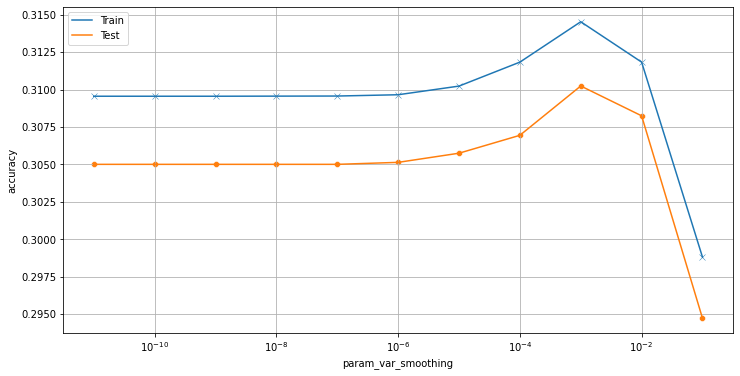

In [20]:
gs = GridSearchCV(
    gnb,
    param_grid={"var_smoothing": np.logspace(-11, -1, 11)},
    return_train_score=True,
    scoring="accuracy",
    cv=kfold,
)

gs.fit(x_train_scaled_45_20, y_train_45_20)
plot_grid_search_results2(gs)
plt.ylabel("accuracy");plt.xscale("log")
plt.grid(True)

The maximum accuracy can be achieved with the var_smoothing=1e-3 for this classifier and the accuracy of the cross validated testing data is around 31%. To further prove this, the model is run again with the optimized parameter and accuracy for the unseen data is calculated.

In [21]:
gnb = GaussianNB(var_smoothing=1e-3)
gnb.fit(x_train_scaled_45_20, y_train_45_20)
y_pred_train_gnb = gnb.predict(x_train_scaled_45_20)
y_pred_test_gnb = gnb.predict(x_test_scaled_45_20)
accuracy_train_gnb=(y_train_45_20 == y_pred_train_gnb).sum()/x_train_scaled_45_20.shape[0]
accuracy_test_gnb=(y_test_45_20 == y_pred_test_gnb).sum()/x_test_scaled_45_20.shape[0]

accuracy_train_gnb,accuracy_test_gnb

(0.3138020833333333, 0.30416068866571017)

The accuracy of the GaussianNB model with the unseen data is 30.42%

## kNN Classifier

For kNN Classifier, at first the model was built with defuault parameters (n_neighbors=5 and p=2). 

In [46]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_jobs=-1)
knn.fit(x_train_scaled_45_20, y_train_45_20)
y_pred_train_knn = knn.predict(x_train_scaled_45_20)
y_pred_test_knn = knn.predict(x_test_scaled_45_20)
accuracy_train_knn=(y_train_45_20 == y_pred_train_knn).sum()/x_train_scaled_45_20.shape[0]
accuracy_test_knn=(y_test_45_20 == y_pred_test_knn).sum()/x_test_scaled_45_20.shape[0]
accuracy_train_knn, accuracy_test_knn

(0.6003401360544217, 0.42802486848397897)

The accuracy is not that high but it is higher than Gaussian Naive Bayes method. Therefore, I will optimize this method too. Before running the cross validation, I tried to optimize the p value at first.

In [48]:
knn = KNeighborsClassifier(n_jobs=-1,p=1)
knn.fit(x_train_scaled_45_20, y_train_45_20)
y_pred_train_knn = knn.predict(x_train_scaled_45_20)
y_pred_test_knn = knn.predict(x_test_scaled_45_20)
accuracy_train_knn=(y_train_45_20 == y_pred_train_knn).sum()/x_train_scaled_45_20.shape[0]
accuracy_test_knn=(y_test_45_20 == y_pred_test_knn).sum()/x_test_scaled_45_20.shape[0]
accuracy_train_knn, accuracy_test_knn

(0.6271789965986394, 0.46293639406982307)

Since accuracy is higher for p=1 (46.29% compared to 42.8%) with default n_neighbors=5, I will n_neighbors with p=1. Since accuracy of the testing data is totally for an unseen data, I use that score to optimize the model.

Next, I will vary the n_neighbors to 3 and 8 to check the direction of the accuracy with the model.

In [88]:
# n_neighbors=8
knn = KNeighborsClassifier(n_jobs=-1,p=1,n_neighbors=8)
knn.fit(x_train_scaled_45_20, y_train_45_20)
y_pred_train_knn = knn.predict(x_train_scaled_45_20)
y_pred_test_knn = knn.predict(x_test_scaled_45_20)
accuracy_train_knn=(y_train_45_20 == y_pred_train_knn).sum()/x_train_scaled_45_20.shape[0]
accuracy_test_knn=(y_test_45_20 == y_pred_test_knn).sum()/x_test_scaled_45_20.shape[0]
accuracy_train_knn, accuracy_test_knn

(0.5780984268707483, 0.453610712577714)

In [89]:
# n_neighbors=3
knn = KNeighborsClassifier(n_jobs=-1,p=1,n_neighbors=3)
knn.fit(x_train_scaled_45_20, y_train_45_20)
y_pred_train_knn = knn.predict(x_train_scaled_45_20)
y_pred_test_knn = knn.predict(x_test_scaled_45_20)
accuracy_train_knn=(y_train_45_20 == y_pred_train_knn).sum()/x_train_scaled_45_20.shape[0]
accuracy_test_knn=(y_test_45_20 == y_pred_test_knn).sum()/x_test_scaled_45_20.shape[0]
accuracy_train_knn, accuracy_test_knn

(0.6696428571428571, 0.4581539933046389)

Therefore, it is evident that the optimized model for knn is with n_neighbors=5 and p=1. The final model is

In [91]:
knn = KNeighborsClassifier(n_jobs=-1,p=1,n_neighbors=5)
knn.fit(x_train_scaled_45_20, y_train_45_20)
y_pred_train_knn = knn.predict(x_train_scaled_45_20)
y_pred_test_knn = knn.predict(x_test_scaled_45_20)
accuracy_train_knn=(y_train_45_20 == y_pred_train_knn).sum()/x_train_scaled_45_20.shape[0]
accuracy_test_knn=(y_test_45_20 == y_pred_test_knn).sum()/x_test_scaled_45_20.shape[0]
accuracy_train_knn, accuracy_test_knn

(0.6271789965986394, 0.46293639406982307)

With KNN classifier the accuracy of the unseen test data is 46.3%

## Random Forest Classifier

Since none of the above methods give a good accuracy, I used random forest classifier at next. This follows ensemble method for classification.

In [11]:
from sklearn.ensemble import RandomForestClassifier

In [10]:
# Using default parameters at first 
# Default:(n_estimators=100,criterion="gini",ccp_alpha=0, max_features='sqrt', min_samples_leaf=1, min_samples_split=2)
rf1=RandomForestClassifier(random_state=0, n_jobs=-1)

In [11]:
rf1_45=rf1
rf1_45.fit(x_train_scaled_45_20, y_train_45_20)
y_pred_train_rf1_45 = rf1_45.predict(x_train_scaled_45_20)
y_pred_test_rf1_45 = rf1_45.predict(x_test_scaled_45_20)
accuracy_train_rf=(y_train_45_20 == y_pred_train_rf1_45).sum()/x_train_scaled_45_20.shape[0]
accuracy_test_rf=(y_test_45_20 == y_pred_test_rf1_45).sum()/x_test_scaled_45_20.shape[0]

In [27]:
accuracy_train_rf, accuracy_test_rf

(1.0, 0.5758010521281683)

From the defulat hyper-parameters, train accuracy is 100% and validation score with unseen data is 57.58%. Next I tried to optimize the hyperparameters.

At first, I tried to optimize the number of estimators via grid search.

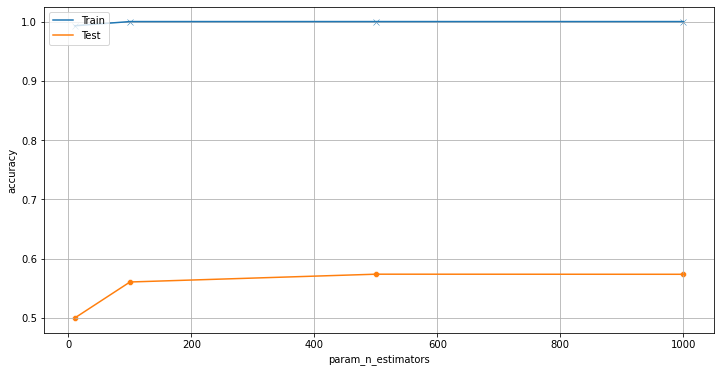

In [28]:
rf1=RandomForestClassifier(random_state=0, n_jobs=-1)
gs = GridSearchCV(
    rf1,
    param_grid={"n_estimators": np.array([10, 100, 500, 1000])},
    return_train_score=True,
    scoring="accuracy",
    cv=kfold
)

gs.fit(x_train_scaled_45_20, y_train_45_20)
plot_grid_search_results2(gs)
plt.ylabel("accuracy");
plt.grid(True)

In [31]:
gs.cv_results_.get('mean_test_score')

array([0.49952173, 0.56042735, 0.57358102, 0.57342161])

The maximum accuracty is found when n_estimators = 500. Therefore I will use this value for next optimization of ccp_alpha

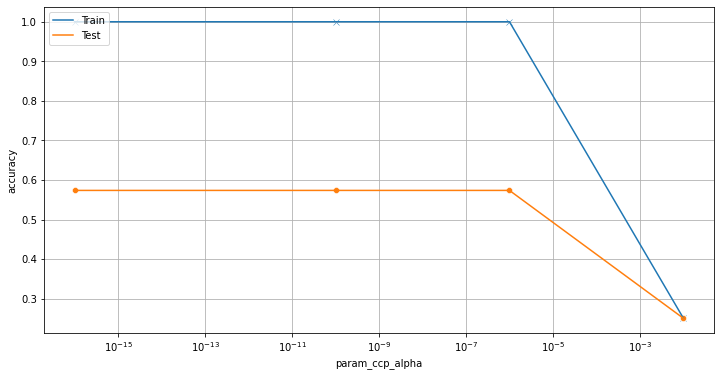

In [32]:
rf1=RandomForestClassifier(random_state=0, n_jobs=-1,n_estimators=500)
gs = GridSearchCV(
    rf1,
    param_grid={"ccp_alpha": np.array([1e-16, 1e-10, 1e-6, 1e-2])},
    return_train_score=True,
    scoring="accuracy",
    cv=kfold
)

gs.fit(x_train_scaled_45_20, y_train_45_20)
plot_grid_search_results2(gs)
plt.ylabel("accuracy");plt.xscale('log');
plt.grid(True)

In [33]:
gs.cv_results_.get('mean_test_score')

array([0.57358102, 0.57358102, 0.57358102, 0.25029229])

The maximum accuracty is found when ccp_alpha<=1e-6. Therefore, I used ccp_alpha=1e-10 for the next level of optimization of criterion.

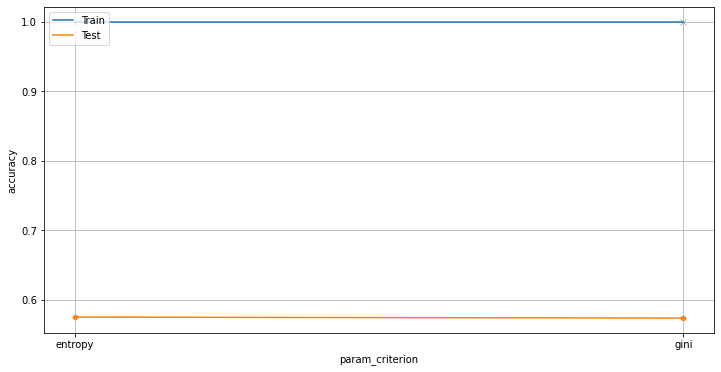

In [34]:
rf1=RandomForestClassifier(random_state=0, n_jobs=-1,n_estimators=500,ccp_alpha=1e-10)
gs = GridSearchCV(
    rf1,
    param_grid={"criterion": ["entropy", "gini"]},
    return_train_score=True,
    scoring="accuracy",
    cv=kfold
)

gs.fit(x_train_scaled_45_20, y_train_45_20)
plot_grid_search_results2(gs)
plt.ylabel("accuracy");
plt.grid(True)

In [35]:
gs.cv_results_.get('mean_test_score')

array([0.5749628 , 0.57358102])

Since 'criterion' = 'entropy' gives higher accuracy, this is selected for next level of optimization. Since I changed the parameters, I am checking the accuracy with n_estimators=1000 next as previously they gave almost similar accuracy.

In [38]:
rf1=RandomForestClassifier(random_state=0, n_jobs=-1,n_estimators=1000,ccp_alpha=1e-10,criterion="entropy")

rf1_45=rf1
rf1_45.fit(x_train_scaled_45_20, y_train_45_20)
y_pred_train_rf1_45 = rf1_45.predict(x_train_scaled_45_20)
y_pred_test_rf1_45 = rf1_45.predict(x_test_scaled_45_20)
accuracy_train_rf=(y_train_45_20 == y_pred_train_rf1_45).sum()/x_train_scaled_45_20.shape[0]
accuracy_test_rf=(y_test_45_20 == y_pred_test_rf1_45).sum()/x_test_scaled_45_20.shape[0]
accuracy_train_rf,accuracy_test_rf

(1.0, 0.5920612147297943)

For unseen data with n_estimators=1000, validation accuracy is 59.2% which is higher than 57.5% with n_estimators=500. Therefore, I used n_estimators=1000 for optimization of max_features.

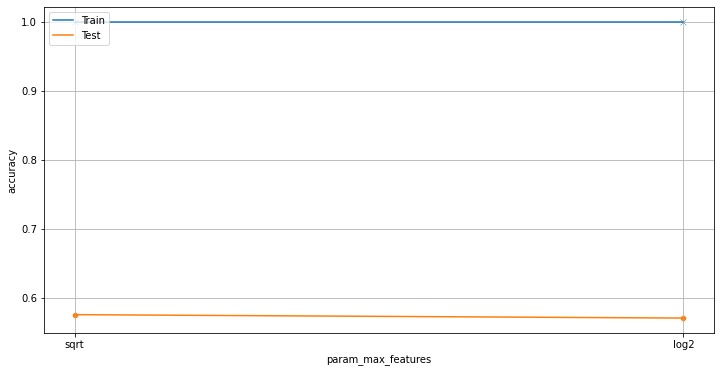

In [39]:
rf1=RandomForestClassifier(random_state=0, n_jobs=-1,n_estimators=1000,ccp_alpha=1e-10,criterion="entropy")
gs = GridSearchCV(
    rf1,
    param_grid={"max_features": ["sqrt", "log2"]},
    return_train_score=True,
    scoring="accuracy",
    cv=kfold
)

gs.fit(x_train_scaled_45_20, y_train_45_20)
plot_grid_search_results2(gs)
plt.ylabel("accuracy");
plt.grid(True)

In [40]:
gs.cv_results_.get('mean_test_score')

array([0.57583983, 0.57089721])

Since 'max_features' = 'sqrt' gives higher accuracy, this is selected for next optimization of min_samples_leaf and min_samples_split. 

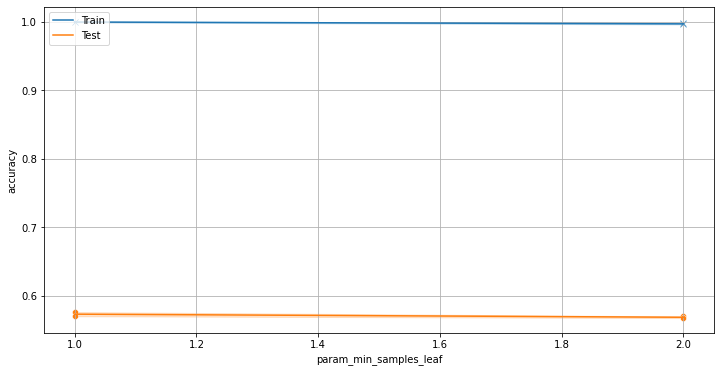

In [41]:
rf1=RandomForestClassifier(random_state=0, n_jobs=-1,n_estimators=1000,ccp_alpha=1e-10,criterion="entropy")
gs = GridSearchCV(
    rf1,
    param_grid={"min_samples_leaf": [1, 2], "min_samples_split": [2, 5]},
    return_train_score=True,
    scoring="accuracy",
    cv=kfold
)

gs.fit(x_train_scaled_45_20, y_train_45_20)
plot_grid_search_results2(gs)
plt.ylabel("accuracy");
plt.grid(True)

In [42]:
gs.cv_results_.get('mean_test_score')

array([0.57583983, 0.56975452, 0.56946228, 0.56709715])

Since the variation in min_samples_leaf and min_samples_split don't increase the accuracy from the deafult values of those, I kept those values at the default. Now, Random Forest Classifier has a parameter called oob_score for generalization of the accuracy. I used that for the final model. Therefore the final model with this feature size is give beolow.

In [12]:
rf1=RandomForestClassifier(oob_score=True, random_state=0,n_estimators=1000,criterion="entropy",ccp_alpha=1e-10, max_features='sqrt', min_samples_leaf=1, min_samples_split=2, n_jobs=-1)

In [13]:
rf1_45=rf1
rf1_45.fit(x_train_scaled_45_20, y_train_45_20)
y_pred_train_rf1_45 = rf1_45.predict(x_train_scaled_45_20)
y_pred_test_rf1_45 = rf1_45.predict(x_test_scaled_45_20)
accuracy_train_rf=(y_train_45_20 == y_pred_train_rf1_45).sum()/x_train_scaled_45_20.shape[0]
accuracy_test_rf=(y_test_45_20 == y_pred_test_rf1_45).sum()/x_test_scaled_45_20.shape[0]
accuracy_train_rf, accuracy_test_rf

(1.0, 0.5920612147297943)

In [14]:
rf1_45.oob_score_

0.5848214285714286

Even though cross-validation score was 57.5%, with the unseen data the accuracy is 59.5%. Since I activated oob_score for the classifier, I used that for the model accuracy. Therefore, accuracy of this model with 45 bins of (sin(theta))^2 feature and 20 coefficient of DST transform is 58.48%.

Now, I will just vary the feature size to check whether the accuracy can be increased. oob_score will be used for model accuracy. 
At first I will vary the number of DST coefficients from 25 to 40 with a step of 5 and then check their oob_score.

In [52]:
# 25 DST coefficients
# feature extraction 
nbin_sin2theta=45;start_bin=1;end_bin=16;dst_coeff=25;
base_feature_training,final_feature_training_45_25=calculate_features(training_data_filepath,nbin_sin2theta,start_bin,end_bin,dst_coeff)
# train-test split
x_train_45_25, x_test_45_25, y_train_45_25, y_test_45_25 = train_test_split(final_feature_training_45_25, original_labels, test_size=0.1, random_state=0)
#data scaling
minmax_scaler_45_25=minmax_scaler
minmax_scaler_45_25.fit(x_train_45_25)
x_test_scaled_45_25=minmax_scaler_45_25.transform(x_test_45_25)
x_train_scaled_45_25=minmax_scaler_45_25.transform(x_train_45_25)
# model 
rf1_45_25=rf1
rf1_45_25.fit(x_train_scaled_45_25, y_train_45_25)
y_pred_train_rf1_45_25 = rf1_45_25.predict(x_train_scaled_45_25)
y_pred_test_rf1_45_25 = rf1_45_25.predict(x_test_scaled_45_25)
accuracy_train_rf=(y_train_45_25 == y_pred_train_rf1_45_25).sum()/x_train_scaled_45_25.shape[0]
accuracy_test_rf=(y_test_45_25 == y_pred_test_rf1_45_25).sum()/x_test_scaled_45_25.shape[0]
# Accuracies
accuracy_train_rf, accuracy_test_rf, rf1_45_25.oob_score_

(1.0, 0.5951697752271641, 0.5871598639455783)

In [53]:
# 30 DST coefficients
# feature extraction 
nbin_sin2theta=45;start_bin=1;end_bin=16;dst_coeff=30;
base_feature_training,final_feature_training_45_30=calculate_features(training_data_filepath,nbin_sin2theta,start_bin,end_bin,dst_coeff)
# train-test split
x_train_45_30, x_test_45_30, y_train_45_30, y_test_45_30 = train_test_split(final_feature_training_45_30, original_labels, test_size=0.1, random_state=0)
#data scaling
minmax_scaler_45_30=minmax_scaler
minmax_scaler_45_30.fit(x_train_45_30)
x_test_scaled_45_30=minmax_scaler_45_30.transform(x_test_45_30)
x_train_scaled_45_30=minmax_scaler_45_30.transform(x_train_45_30)
# model 
rf1_45_30=rf1
rf1_45_30.fit(x_train_scaled_45_30, y_train_45_30)
y_pred_train_rf1_45_30 = rf1_45_30.predict(x_train_scaled_45_30)
y_pred_test_rf1_45_30 = rf1_45_30.predict(x_test_scaled_45_30)
accuracy_train_rf=(y_train_45_30 == y_pred_train_rf1_45_30).sum()/x_train_scaled_45_30.shape[0]
accuracy_test_rf=(y_test_45_30 == y_pred_test_rf1_45_30).sum()/x_test_scaled_45_30.shape[0]
# Accuracies
accuracy_train_rf, accuracy_test_rf, rf1_45_30.oob_score_

(1.0, 0.5913438546150167, 0.5882227891156463)

In [54]:
# 35 DST coefficients
# feature extraction 
nbin_sin2theta=45;start_bin=1;end_bin=16;dst_coeff=35;
base_feature_training,final_feature_training_45_35=calculate_features(training_data_filepath,nbin_sin2theta,start_bin,end_bin,dst_coeff)
# train-test split
x_train_45_35, x_test_45_35, y_train_45_35, y_test_45_35 = train_test_split(final_feature_training_45_35, original_labels, test_size=0.1, random_state=0)
#data scaling
minmax_scaler_45_35=minmax_scaler
minmax_scaler_45_35.fit(x_train_45_35)
x_test_scaled_45_35=minmax_scaler_45_35.transform(x_test_45_35)
x_train_scaled_45_35=minmax_scaler_45_35.transform(x_train_45_35)
# model 
rf1_45_35=rf1
rf1_45_35.fit(x_train_scaled_45_35, y_train_45_35)
y_pred_train_rf1_45_35 = rf1_45_35.predict(x_train_scaled_45_35)
y_pred_test_rf1_45_35 = rf1_45_35.predict(x_test_scaled_45_35)
accuracy_train_rf=(y_train_45_35 == y_pred_train_rf1_45_35).sum()/x_train_scaled_45_35.shape[0]
accuracy_test_rf=(y_test_45_35 == y_pred_test_rf1_45_35).sum()/x_test_scaled_45_35.shape[0]
# Accuracies
accuracy_train_rf, accuracy_test_rf, rf1_45_35.oob_score_

(1.0, 0.5980392156862745, 0.5871598639455783)

In [55]:
# 40 DST coefficients
# feature extraction 
nbin_sin2theta=45;start_bin=1;end_bin=16;dst_coeff=40;
base_feature_training,final_feature_training_45_40=calculate_features(training_data_filepath,nbin_sin2theta,start_bin,end_bin,dst_coeff)
# train-test split
x_train_45_40, x_test_45_40, y_train_45_40, y_test_45_40 = train_test_split(final_feature_training_45_40, original_labels, test_size=0.1, random_state=0)
#data scaling
minmax_scaler_45_40=minmax_scaler
minmax_scaler_45_40.fit(x_train_45_40)
x_test_scaled_45_40=minmax_scaler_45_40.transform(x_test_45_40)
x_train_scaled_45_40=minmax_scaler_45_40.transform(x_train_45_40)
# model 
rf1_45_40=rf1
rf1_45_40.fit(x_train_scaled_45_40, y_train_45_40)
y_pred_train_rf1_45_40 = rf1_45_40.predict(x_train_scaled_45_40)
y_pred_test_rf1_45_40 = rf1_45_40.predict(x_test_scaled_45_40)
accuracy_train_rf=(y_train_45_40 == y_pred_train_rf1_45_40).sum()/x_train_scaled_45_40.shape[0]
accuracy_test_rf=(y_test_45_40 == y_pred_test_rf1_45_40).sum()/x_test_scaled_45_40.shape[0]
# Accuracies
accuracy_train_rf, accuracy_test_rf, rf1_45_40.oob_score_

(1.0, 0.592778574844572, 0.5862829506802721)

OOB scores are 58.48%, 58.72%, 58.82%, 58.72% and 58.63% for 20, 25, 30, 35 and 40 DST coefficients respectively. Therefore 30 considering 30 DST coefficents for the feature size is optimal. Next we will try to optimize the binning of (sin(theta))^2 by varrying the end bin from 30 to 60 with endbin from 11 to 21 as we optimized the previous model by end bin = 16.

In [14]:
# 30 DST coefficients & 30 bins
# feature extraction 
nbin_sin2theta=30;start_bin=1;end_bin=11;dst_coeff=30;
base_feature_training,final_feature_training_30_30=calculate_features(training_data_filepath,nbin_sin2theta,start_bin,end_bin,dst_coeff)
# train-test split
x_train_30_30, x_test_30_30, y_train_30_30, y_test_30_30 = train_test_split(final_feature_training_30_30, original_labels, test_size=0.1, random_state=0)
#data scaling
minmax_scaler_30_30=minmax_scaler
minmax_scaler_30_30.fit(x_train_30_30)
x_test_scaled_30_30=minmax_scaler_30_30.transform(x_test_30_30)
x_train_scaled_30_30=minmax_scaler_30_30.transform(x_train_30_30)
# model 
rf1_30_30=RandomForestClassifier(oob_score=True, random_state=0,n_estimators=1000,criterion="entropy",ccp_alpha=1e-10, max_features='sqrt', min_samples_leaf=1, min_samples_split=2, n_jobs=-1)
rf1_30_30.fit(x_train_scaled_30_30, y_train_30_30)
y_pred_train_rf1_30_30 = rf1_30_30.predict(x_train_scaled_30_30)
y_pred_test_rf1_30_30 = rf1_30_30.predict(x_test_scaled_30_30)
accuracy_train_rf=(y_train_30_30 == y_pred_train_rf1_30_30).sum()/x_train_scaled_30_30.shape[0]
accuracy_test_rf=(y_test_30_30 == y_pred_test_rf1_30_30).sum()/x_test_scaled_30_30.shape[0]
# Accuracies
accuracy_train_rf, accuracy_test_rf, rf1_30_30.oob_score_

(1.0, 0.5951697752271641, 0.5887011054421769)

In [57]:
# 30 DST coefficients & 60 bins
# feature extraction 
nbin_sin2theta=60;start_bin=1;end_bin=21;dst_coeff=30;
base_feature_training,final_feature_training_60_30=calculate_features(training_data_filepath,nbin_sin2theta,start_bin,end_bin,dst_coeff)
# train-test split
x_train_60_30, x_test_60_30, y_train_60_30, y_test_60_30 = train_test_split(final_feature_training_60_30, original_labels, test_size=0.1, random_state=0)
#data scaling
minmax_scaler_60_30=minmax_scaler
minmax_scaler_60_30.fit(x_train_60_30)
x_test_scaled_60_30=minmax_scaler_60_30.transform(x_test_60_30)
x_train_scaled_60_30=minmax_scaler_60_30.transform(x_train_60_30)
# model 
rf1_60_30=rf1
rf1_60_30.fit(x_train_scaled_60_30, y_train_60_30)
y_pred_train_rf1_60_30 = rf1_60_30.predict(x_train_scaled_60_30)
y_pred_test_rf1_60_30 = rf1_60_30.predict(x_test_scaled_60_30)
accuracy_train_rf=(y_train_60_30 == y_pred_train_rf1_60_30).sum()/x_train_scaled_60_30.shape[0]
accuracy_test_rf=(y_test_60_30 == y_pred_test_rf1_60_30).sum()/x_test_scaled_60_30.shape[0]
# Accuracies
accuracy_train_rf, accuracy_test_rf, rf1_60_30.oob_score_

(1.0, 0.5877570540411287, 0.5817389455782312)

It is evident from the OOB scores that 30 and 45 bins of (sin(theta))^2 gives almost same result and 60 bins has lower OOB score. However, with 30 bins unseen test datas also have a little higher accuracy (59.5%) compared to 59.13% of 45 bins. 

Therefore, I will conclude that with random forest classifier the maximum accuracy can be achieved by selecting  30 bins of (sin(theta))^2 and 30 DST coefficients. The model has OOB score of 58.87% and validation accuracy with unseen data is 59.5% .

So, the final model is:

In [15]:
rf1_30_30=RandomForestClassifier(oob_score=True, random_state=0,n_estimators=1000,criterion="entropy",ccp_alpha=1e-10, max_features='sqrt', min_samples_leaf=1, min_samples_split=2, n_jobs=-1)

In [16]:
rf1_30_30.fit(x_train_scaled_30_30, y_train_30_30)
y_pred_train_rf1_30_30 = rf1_30_30.predict(x_train_scaled_30_30)
y_pred_test_rf1_30_30 = rf1_30_30.predict(x_test_scaled_30_30)
accuracy_train_rf=(y_train_30_30 == y_pred_train_rf1_30_30).sum()/x_train_scaled_30_30.shape[0]
accuracy_test_rf=(y_test_30_30 == y_pred_test_rf1_30_30).sum()/x_test_scaled_30_30.shape[0]
# Accuracies
accuracy_train_rf, accuracy_test_rf, rf1_30_30.oob_score_

(1.0, 0.5951697752271641, 0.5887011054421769)

C:\Users\Raihan\Anaconda3\envs\nano281\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


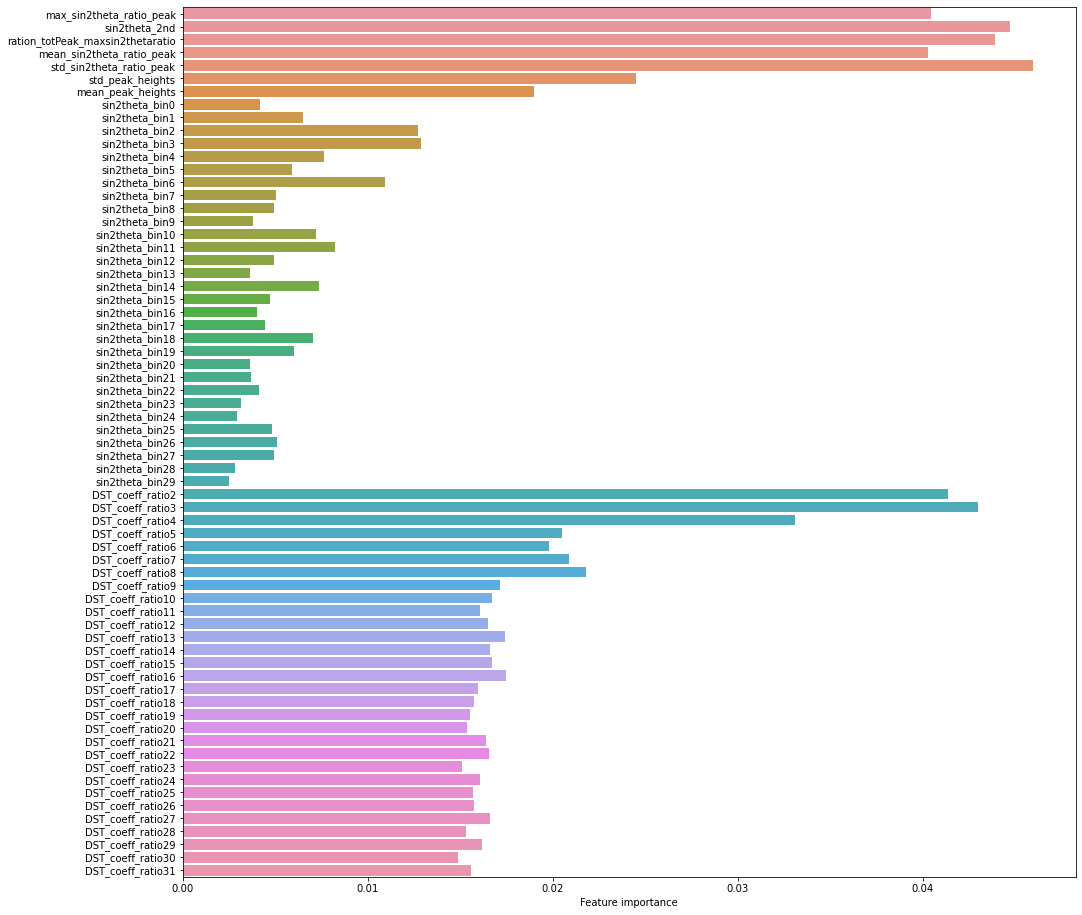

In [78]:
plt.subplots(figsize=(16, 16))
sns.barplot(rf1_30_30.feature_importances_, list(final_feature_training_30_30.columns), orient='h')
plt.xlabel("Feature importance");

In [44]:
from sklearn.metrics import confusion_matrix

def get_cm(y, y_pred):
    train_cm = confusion_matrix(y, y_pred)

    column_labels = ['class_%d'%i for i in range(1, 15)]

    return pd.DataFrame(train_cm, columns=['pred_'+i for i in column_labels], 
                              index=['true_' + i for i in column_labels])

#train_cm_df = get_cm(y_train, y_pred_train_random_for3)
test_cm_df = get_cm(y_test_30_30,y_pred_test_rf1_30_30)
#print('Train data', train_cm_df)
TP=[test_cm_df.iloc[i,i] for i in range(14)]
TN=np.array(test_cm_df.sum(axis=1))-TP
FP=np.array(test_cm_df.sum())-TP
#test_cm_df
#print('Test data', test_cm_df)

In [47]:
test_cm_df

,pred_class_1,pred_class_2,pred_class_3,pred_class_4,pred_class_5,pred_class_6,pred_class_7,pred_class_8,pred_class_9,pred_class_10,pred_class_11,pred_class_12,pred_class_13,pred_class_14
true_class_1,243,0,1,0,4,4,74,31,0,0,26,2,0,2
true_class_2,0,377,1,1,2,2,0,1,0,1,0,0,0,0
true_class_3,0,0,95,2,2,5,1,2,0,0,0,0,2,2
true_class_4,2,0,0,176,1,4,1,9,0,0,1,4,0,5
true_class_5,9,1,1,4,306,27,2,12,0,0,1,6,7,2
true_class_6,23,6,0,4,25,267,16,43,0,0,9,5,11,7
true_class_7,102,0,0,0,2,3,148,51,0,0,67,3,0,4
true_class_8,42,1,0,4,7,20,68,168,0,1,37,17,5,8
true_class_9,0,1,0,0,3,6,0,5,11,0,1,2,8,0
true_class_10,3,1,1,1,10,12,3,12,0,39,5,5,6,1


From the above plot, we can easily understand the importance of different features. I calculated ration of (sin(theta))^2 using the a=[(sin(theta))^2 at the first peak]. According to the graph, the most important features are,

(1) Standard  deviation of the (sin(theta))^2/a values at the peaks. How the peak planes are spreaded

(2) (sin(theta))^2/a for the 2nd peak. This value can easily identify symmetric crystal. For example, for cP it should be just 2 

(3) Ration of total peaks to (sin(theta))^2/a. This value also gives the information of symmetry.

(4) Maximum value of (sin(theta))^2/a. The higher the value the more allowable values for peak diffraction (information of symmetry)

(5) (6) (7) 2nd, 3rd and 4th coefficient of DST transform. In other words, it takes information of the dominant peaks along with the full spectrum

(8) (9) Meand and standard deviation of the peak heights are also important. However, their contribution to the determination of the crystal structure is not that high as like the sine of the peak angles. The model also shows that.

## Light GBM Classifier (Gradient Boost Classifier)

Since for random forest classifier, I have already optimized the features, I will use that feature to optimize this light gbm classifier. Also since n_estimators=1000 gives the best result for random forest classifier, I will use the same n_estimators for this model. Similarly min_samples_leaf (equivalent to min_child_samples in LGBM) of 1 and min_samples_split of 2 give the best result for Random Forest Classifier model, therefore I will use those same parameters for these model too.

In [79]:
from lightgbm import LGBMClassifier
lightgbm_model = LGBMClassifier(random_state=0,n_estimators=1000, reg_alpha='1', lambda_l2='1', min_child_samples=1, min_samples_split=2, n_jobs=-1)

In [80]:
lightgbm_model.fit(x_train_scaled_30_30, y_train_30_30)
y_pred_train_lgbm_30_30 = lightgbm_model.predict(x_train_scaled_30_30)
y_pred_test_lgbm_30_30 = lightgbm_model.predict(x_test_scaled_30_30)
[(y_train_30_30 == y_pred_train_lgbm_30_30).sum()/x_train_scaled_30_30.shape[0], (y_test_30_30 == y_pred_test_lgbm_30_30).sum()/x_test_scaled_30_30.shape[0]]

[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1


[0.9999734268707483, 0.599713055954089]

In [81]:
accuracy_train_lgbm_30_30=(y_train_30_30 == y_pred_train_lgbm_30_30).sum()/x_train_scaled_30_30.shape[0]
accuracy_test_lgbm_30_30=(y_test_30_30 == y_pred_test_lgbm_30_30).sum()/x_test_scaled_30_30.shape[0]
accuracy_train_lgbm_30_30, accuracy_test_lgbm_30_30

(0.9999734268707483, 0.599713055954089)

As it can be seen with the light gbm model the accuracy is 59.97% for the unseen data whereas for the random forest classifier model it was 59.5%. Therefore, by far this is the best model.

In order to optimize the parameters, I will vary reg_alpha and lambda_l2 and check the accuracy on the test data to optimize the mdoel since test data is unseen to the model and therefore it is fair to judge the model based on this performance. 

In [82]:
# Decreasing lambda_l2
light1=LGBMClassifier(random_state=0,n_estimators=1000, reg_alpha='1', lambda_l2='0', min_child_samples=1, min_samples_split=2, n_jobs=-1)
light1.fit(x_train_scaled_30_30, y_train_30_30)
y_pred_train_lgbm_30_30 = light1.predict(x_train_scaled_30_30)
y_pred_test_lgbm_30_30 = light1.predict(x_test_scaled_30_30)
(y_test_30_30 == y_pred_test_lgbm_30_30).sum()/x_test_scaled_30_30.shape[0]

[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


0.5915829746532759

In [83]:
# Decreasing lambda_l2
light1=LGBMClassifier(random_state=0,n_estimators=1000, reg_alpha='1', lambda_l2='0.5', min_child_samples=1, min_samples_split=2, n_jobs=-1)
light1.fit(x_train_scaled_30_30, y_train_30_30)
y_pred_train_lgbm_30_30 = light1.predict(x_train_scaled_30_30)
y_pred_test_lgbm_30_30 = light1.predict(x_test_scaled_30_30)
(y_test_30_30 == y_pred_test_lgbm_30_30).sum()/x_test_scaled_30_30.shape[0]

[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5


0.59636537541846

In [84]:
# Decreasing reg_alpha
light1=LGBMClassifier(random_state=0,n_estimators=1000, reg_alpha='0', lambda_l2='1', min_child_samples=1, min_samples_split=2, n_jobs=-1)
light1.fit(x_train_scaled_30_30, y_train_30_30)
y_pred_train_lgbm_30_30 = light1.predict(x_train_scaled_30_30)
y_pred_test_lgbm_30_30 = light1.predict(x_test_scaled_30_30)
(y_test_30_30 == y_pred_test_lgbm_30_30).sum()/x_test_scaled_30_30.shape[0]

[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1


0.6068866571018652

In [85]:
# Decreasing reg_alpha
light1=LGBMClassifier(random_state=0,n_estimators=1000, reg_alpha='0.5', lambda_l2='1', min_child_samples=1, min_samples_split=2, n_jobs=-1)
light1.fit(x_train_scaled_30_30, y_train_30_30)
y_pred_train_lgbm_30_30 = light1.predict(x_train_scaled_30_30)
y_pred_test_lgbm_30_30 = light1.predict(x_test_scaled_30_30)
(y_test_30_30 == y_pred_test_lgbm_30_30).sum()/x_test_scaled_30_30.shape[0]

[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1


0.6035389765662362

In [86]:
# Increasing lambda_l2
light1=LGBMClassifier(random_state=0,n_estimators=1000, reg_alpha='1', lambda_l2='2', min_child_samples=1, min_samples_split=2, n_jobs=-1)
light1.fit(x_train_scaled_30_30, y_train_30_30)
y_pred_train_lgbm_30_30 = light1.predict(x_train_scaled_30_30)
y_pred_test_lgbm_30_30 = light1.predict(x_test_scaled_30_30)
(y_test_30_30 == y_pred_test_lgbm_30_30).sum()/x_test_scaled_30_30.shape[0]

[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] lambda_l2 is set=2, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2


0.6016260162601627

In [87]:
# Increasing reg_alpha
light1=LGBMClassifier(random_state=0,n_estimators=1000, reg_alpha='2', lambda_l2='1', min_child_samples=1, min_samples_split=2, n_jobs=-1)
light1.fit(x_train_scaled_30_30, y_train_30_30)
y_pred_train_lgbm_30_30 = light1.predict(x_train_scaled_30_30)
y_pred_test_lgbm_30_30 = light1.predict(x_test_scaled_30_30)
(y_test_30_30 == y_pred_test_lgbm_30_30).sum()/x_test_scaled_30_30.shape[0]

[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1


0.5982783357245337

From the model accuracy scores for different lambda_l2 and reg_alpha, it can be easily seen that, the highest accuracy can be obtained for reg_alpha=0 and lambda_l2=1. Therefore these parameters are chosen for the final model.

In [94]:
light_final=LGBMClassifier(random_state=0,n_estimators=1000, reg_alpha='0', lambda_l2='1', min_child_samples=1, min_samples_split=2, n_jobs=-1)
light_final.fit(x_train_scaled_30_30, y_train_30_30)
y_pred_train_lgbm_30_30 = light_final.predict(x_train_scaled_30_30)
y_pred_test_lgbm_30_30 = light_final.predict(x_test_scaled_30_30)
accuracy_test_lgbm=(y_test_30_30 == y_pred_test_lgbm_30_30).sum()/x_test_scaled_30_30.shape[0]
accuracy_train_lgbm=(y_train_30_30 == y_pred_train_lgbm_30_30).sum()/x_train_scaled_30_30.shape[0]

[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1


In [95]:
accuracy_test_lgbm

0.6068866571018652

The accuracy of the light gbm classifier (gradient boost classifier) is 60.69%

# Finding accuracy of GaussianNB and KNN with 30_30

In [97]:
# Gaussian NB
gnb = GaussianNB()
gnb.fit(x_train_scaled_30_30, y_train_30_30)
y_pred_test_gnb = gnb.predict(x_test_scaled_30_30)
accuracy_test_gnb=(y_test_30_30 == y_pred_test_gnb).sum()/x_test_scaled_30_30.shape[0]
accuracy_test_gnb

0.296987087517934

In [98]:
# KNN
knn = KNeighborsClassifier(n_jobs=-1,p=1,n_neighbors=5)
knn.fit(x_train_scaled_30_30, y_train_30_30)
y_pred_test_knn = knn.predict(x_test_scaled_30_30)
accuracy_test_knn=(y_test_30_30 == y_pred_test_knn).sum()/x_test_scaled_30_30.shape[0]
accuracy_test_knn

0.4815877570540411

The accuracy of different models:

GaussianNB: 29.69%

KNN: 48.158%

Random Forest Classifier: 59.52%

Light GBM Classifier:60.69%

## Prediction

In [99]:
nbin_sin2theta=30;start_bin=1;end_bin=11;dst_coeff=30;
base_feature_kaggle,final_feature_kaggle_45_20=calculate_features(kaggle_data_filepath,nbin_sin2theta,start_bin,end_bin,dst_coeff)

In [105]:
minmax_scaler_30_30=minmax_scaler
minmax_scaler_30_30.fit(x_train_30_30)
testtt=minmax_scaler_30_30.transform(final_feature_kaggle_45_20)

In [112]:
y_pred_test_lgbm_30_30k = light_final.predict(testtt)


In [113]:
data_filepath_test="C:\\Users\\Raihan\\Nano281_project\\test.csv"
testt_data=pd.read_csv(data_filepath_test,na_filter=False)

test_predicted_data_lgbm_45=pd.DataFrame(testt_data['id'],columns=['id'])
test_predicted_data_lgbm_45['bravais_lattice']=le.inverse_transform(y_pred_test_lgbm_30_30k)
test_data_out_lgbm_45_filepath="C:\\Users\\Raihan\\Nano281_project\\test_out_v10.csv"
test_predicted_data_lgbm_45.to_csv(test_data_out_lgbm_45_filepath,index=False)

# Saving Model

In [116]:
import pickle
with open('Mohammad Abu_Raihan Miah_random_forest_classifier.pkl',"wb") as f:
    pickle.dump(rf1_30_30, f)

In [117]:
import pickle
with open('Mohammad Abu_Raihan Miah_light_gbm.pkl',"wb") as f:
    pickle.dump(lightgbm_model, f)

In [119]:
with open('Mohammad Abu_Raihan Miah_random_forest_classifier2.pkl',"wb") as f:
    pickle.dump(rf1_45, f)

In [120]:
with open('Mohammad Abu_Raihan Miah_knn.pkl',"wb") as f:
    pickle.dump(knn, f)

In [121]:
with open('Mohammad Abu_Raihan Miah_light_gbm2.pkl',"wb") as f:
    pickle.dump(light_final, f)